In [56]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import functools
import operator

In [57]:
weather_data = pd.read_csv('../../../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../../../data/Plant_1_Generation_Data.csv')

In [58]:
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])

In [59]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,136,15,00:15:00,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,136,30,00:30:00,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,136,45,00:45:00,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,136,60,01:00:00,1


In [60]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))


## AK here before you fit the efficiency (or conversion coefficient) you need to clean the outliers - circled in the image below. OTherwise they weigh too much on the efficiency calculation and give you an incorrect efficiency fit - see the fitted orange line below
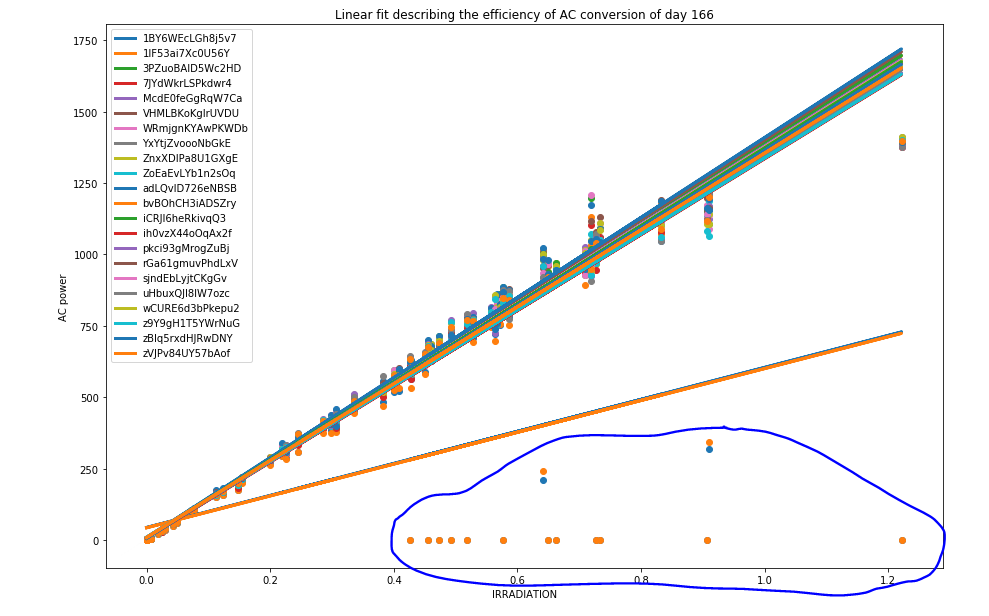

For this reason below we first clean the outliers and then get the conversion coefficients. Here I have used the final cleaned functions for this

In [61]:
def get_outliers_in_time(data, column, groupby_column, output_column_name=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    for i, group in  data.groupby(data[groupby_column]):
        outlier_condition1=group[column]>(group[column].mean() + outlier_limit*group[column].std())
        outlier_condition2=group[column]<(group[column].mean() - outlier_limit*group[column].std())
        data.loc[group[outlier_condition1|outlier_condition2].index, output_column_name]=1
    return data
merged_df=get_outliers_in_time(merged_df, 'DC_POWER', 'HOUR', output_column_name="alarm_DC_conversion_outlier", outlier_limit=3)

In [62]:
def get_conversion_coefficients(data, x_column, y_column, output_column_name="conversion_coefficient"):
    output_df=pd.DataFrame(columns=['SOURCE_KEY', 'DAY', output_column_name])
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            X = day[x_column].values.reshape(-1,1)
            y = day[y_column].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_[0][0]
            output_df=output_df.append(pd.DataFrame({'SOURCE_KEY': [i], 'DAY': [a], output_column_name: [m]}), ignore_index=True)
    return(output_df)
new_d = get_conversion_coefficients(merged_df[(merged_df['MODULE_TEMPERATURE']<=50)&(merged_df["alarm_DC_conversion_outlier"]==0)], 'IRRADIATION', 'DC_POWER', output_column_name="DC_efficiency")

### AK 
I have also cleaned a bit yor functions, setting variables instead of column explicit names

In [63]:
def outlier_detection(data, column, output_column_name, anomaly_limit = 2):
    data[output_column_name] = 0
    for _,d in data.groupby('DAY'):
        col_mean = d[column].mean()
        col_std = d[column].std()
        data.loc[d[(d[column] > col_mean + anomaly_limit * col_std) | 
              (d[column] < col_mean - anomaly_limit * col_std)].index,output_column_name] = 1
    return data
new_d = outlier_detection(new_d, 'DC_efficiency', 'alarm_inefficient_inverter_day')

In [64]:
new_d
# def lowest_efficiency_marker(output_of_Irr_dc_linear_fit):
    

,SOURCE_KEY,DAY,DC_efficiency,alarm_inefficient_inverter_day
0,1BY6WEcLGh8j5v7,136,12654.291412,1
1,1BY6WEcLGh8j5v7,137,13815.536158,0
2,1BY6WEcLGh8j5v7,138,12746.229514,1
3,1BY6WEcLGh8j5v7,139,13327.495955,1
4,1BY6WEcLGh8j5v7,140,12703.448115,1
...,...,...,...,...
743,YxYtjZvoooNbGkE,165,13433.000542,0
744,YxYtjZvoooNbGkE,166,14140.402503,0
745,YxYtjZvoooNbGkE,167,13336.728694,0
746,YxYtjZvoooNbGkE,168,14245.533742,0


<AxesSubplot:xlabel='DAY', ylabel='DC_efficiency'>

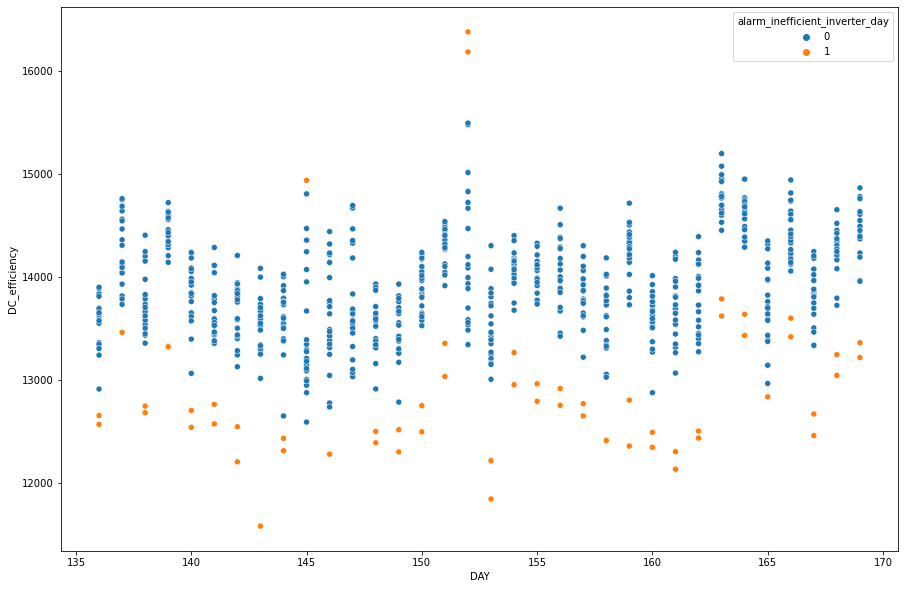

In [65]:
ax=plt.figure(figsize=(15, 10))
sns.scatterplot(x = 'DAY',y = 'DC_efficiency',data = new_d, hue = 'alarm_inefficient_inverter_day')

### AK
Finally to get ther inverters tht have been inefficient for x days in a row we do like below.

In [66]:
new_d['alarm_inefficient_inverter_window']=0
for inv in new_d['SOURCE_KEY'].unique():
    new_d.loc[new_d['SOURCE_KEY']==inv, 'alarm_inefficient_inverter_window']=new_d[new_d['SOURCE_KEY']==inv]['alarm_inefficient_inverter_day'].rolling(window = 7).min()

In [67]:
new_d[new_d['alarm_inefficient_inverter_window']==1]

,SOURCE_KEY,DAY,DC_efficiency,alarm_inefficient_inverter_day,alarm_inefficient_inverter_window
23,1BY6WEcLGh8j5v7,159,12804.167135,1,1.0
346,bvBOhCH3iADSZry,142,12205.070956,1,1.0
363,bvBOhCH3iADSZry,159,12358.037591,1,1.0
364,bvBOhCH3iADSZry,160,12346.333289,1,1.0
365,bvBOhCH3iADSZry,161,12133.818491,1,1.0
366,bvBOhCH3iADSZry,162,12436.674220,1,1.0
367,bvBOhCH3iADSZry,163,13620.426050,1,1.0
368,bvBOhCH3iADSZry,164,13431.064265,1,1.0
369,bvBOhCH3iADSZry,165,12835.550770,1,1.0
370,bvBOhCH3iADSZry,166,13418.392521,1,1.0
